In [1]:
from IPython.display import display, Image
from pprint import pprint
from itertools import chain

from ginv import *
sympy.init_printing()

Условие на классические симметрии
\begin{equation}
\begin{aligned}
\mathbf{2u_{tx}}& + u_{xx} u_{x} - u_{yy} = 0 \\
\mathbf{u_{\varepsilon }}& - F(t, x, y, u, u_{t}, u_{x}, u_{y}) = 0 \\
\end{aligned}
\end{equation}
Для второго уравнения системы введем полные производные от $F$.
\begin{equation}
\begin{aligned}
\frac{dF}{dt} &= F_t  + F_u u_{t} + F_{u_{t}} u_{tt} + F_{u_{x}} u_{tx} + F_{u_{y}} u_{ty}\\
\frac{dF}{dx} &= F_x  + F_u u_{x} + F_{u_{t}} u_{tx} + F_{u_{x}} u_{xx} + F_{u_{y}} u_{xy}\\
\frac{dF}{dy} &= F_y  + F_u u_{y} + F_{u_{t}} u_{ty} + F_{u_{x}} u_{xy} + F_{u_{y}} u_{yy}\\
\end{aligned}
\end{equation}

Условие интегрируемости (совместности) данной системы можно записать через $S$-полином (лексикографическое упорядочение $t \succ x \succ y$)
\begin{equation}
\big(2\mathbf{u_{tx}} + u_{xx} u_{x} - u_{yy})_\varepsilon 
- \mathbf{u_{\varepsilon tx}} + 2\frac{d^2}{dtdx}F = 0
\end{equation}

В последнем уравнении в силу правила дифференцирования Лейбница производная по $\varepsilon $
входит в условие интрегриемости линейно. 
\begin{equation}
 u_{xx} u_{\varepsilon x}  + u_{\varepsilon xx} u_{x} - u_{\varepsilon yy} + 2\frac{d^2}{dtdx}F = 0
\end{equation}
При этом мы можем заменить $u_{\varepsilon }$ на $F$ используя полные производные от $F$.
\begin{equation}
 u_{xx}\frac{d}{dx}F
 +\frac{d^2}{dx^2}F u_{x} - \frac{d^2}{dy^2}F 
+ 2\frac{d^2}{dtdx}F = 0
\end{equation}

Учитывая в силу самого уравнения Линя-Рейснера-Цзяня
\begin{equation}
\begin{aligned}
u_{tx} &= (- u_{xx} u_{x} + u_{yy})/2 \\
u_{txx} &= (- u_{xxx} u_{x} -   u_{xxx} u_{xx} + u_{xyy})/2  \\
u_{txy} &= (-  u_{xxy} u_{x} -  u_{xxx} u_{xy} + u_{yyy})/2  \\
u_{ttx} &= (-  (- u_{xxx} u_{x} -   u_{xxx} u_{xx} + u_{xyy})/2 u_{x} -  u_{xx} (- u_{xx} u_{x} + u_{yy})/2 - \gamma u_{tyy})/2  \\
& \cdots \\
\end{aligned}
\end{equation}
и то что само $F$ не зависит от производных выше первого порядка $u_{t}, u_{x}, u_{y}$ можно получить 
систему линейных уравнений на $F$.

In [2]:
eps, t, x, y = sympy.symbols('ε, t, x, y', real=True)
U = sympy.Function('u')(eps, t, x, y)

u, ut, ux, uy = sympy.symbols('u, u_t, u_x, u_y', real=True)
F = sympy.Function('f')(t, x, y, u, ut, ux, uy)

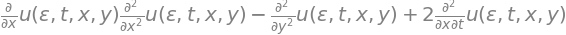

In [3]:
eq1 = 2*U.diff(t, x) + U.diff(x)*U.diff(x, 2)  - U.diff(y, 2)
eq1

In [4]:
func_poly = set([sympy.Add, sympy.Mul, sympy.Pow])
def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a.func in func_poly:
                return a.func(*tuple(cmpct(s) for s in a.args))
            elif a.func != sympy.Derivative:
                return sympy.Symbol(f"{a.func}")
            else:
                m = []
                for xi, k in a.args[1:]:
                    m.append(f"{xi}"*k)
                return sympy.Symbol(f"{a.args[0].func}_{{{''.join(m)}}}", real=True)
    return cmpct(f)

In [5]:
compact(eq1)

In [6]:
compact(eq1.diff(eps))

In [7]:
def Dt(a):
    return a.diff(t) + a.diff(u)*ut + a.diff(ut)*U.diff(t, t)\
         + a.diff(ux)*U.diff(x, t) + a.diff(uy)*U.diff(y, t)
def Dx(a):
    return a.diff(x) + a.diff(u)*ux + a.diff(ut)*U.diff(t, x)\
         + a.diff(ux)*U.diff(x, x) + a.diff(uy)*U.diff(y, x)
def Dy(a):
    return a.diff(y) + a.diff(u)*uy + a.diff(ut)*U.diff(t, y)\
         + a.diff(ux)*U.diff(x, y) + a.diff(uy)*U.diff(y, y)

In [8]:
toD = {
    t: Dt,\
    x: Dx,\
    y: Dy,\
}
def totalD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(totalD(s) for s in a.args))
        elif (eps, 1) not in a.args:
            return a
        else:
            assert a.args[0] == U
            r = F
            for v, l in a.args[1:]:
                if v != eps:
                    for i in range(l):
                        r = toD[v](r)
            return r
eq2 = totalD(eq1.diff(eps)).expand()     

In [9]:
compact(eq2)

In [10]:
s = sympy.solve(eq1, U.diff(t, x))[0]
def sub_eq(a):
    def find(args):
        r = 0
        for v, l in a.args[1:]:
            if v in (t, x):
                r += 1
        return r == 2
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(sub_eq(s) for s in a.args))
        elif a.args[0] != U or not find(a.args):
            return a
        else:
            r = s
            for v, l in a.args[1:]:
                if v in (t, x):
                    l -= 1
                r = r.diff(v, l)
            return r
eq3 = sub_eq(eq2).expand()
eq3 = sub_eq(eq3).expand()
eq3 = sub_eq(eq3).expand()

In [11]:
compact(eq3)

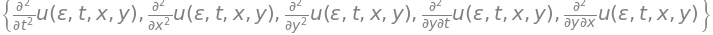

In [12]:
toU = {
    U.diff(t): ut,\
    U.diff(x): ux,\
    U.diff(y): uy,\
}
DF = set()
def lstD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(lstD(s) for s in a.args))
        elif a.args[0] != U:
            return a
        elif a in toU:
            return toU[a]
        else:
            DF.add(a)
            return a
eq4 = lstD(eq3).expand()
DF

In [13]:
[compact(df) for df in DF]

In [14]:
def to_eqs(a, var):
    for x in var:
        r = []
        for b in a:
            if b:
                r.append([b.coeff(x, i) for i in range(b.as_poly(x).degree()+1) if b.coeff(x, i)])
        a = chain(*r)
    return list(a)

eqs = to_eqs([eq4], DF)
for eq in eqs:
    print(sympy.latex(compact(eq)) + r" = 0, \\")
for eq in eqs:
    display(compact(eq))

2 f_{tu} u_{x} + 2 f_{tx} + 2 f_{uu} u_{t} u_{x} + f_{uu} u_{x}^{3} - f_{uu} u_{y}^{2} + 2 f_{ux} u_{t} + 2 f_{ux} u_{x}^{2} - 2 f_{uy} u_{y} + f_{xx} u_{x} - f_{yy} = 0, \\
2 f_{u_tx} + 2 f_{uu_t} u_{x} = 0, \\
2 f_{tu_y} - 2 f_{u_xy} + 2 f_{u_yx} u_{x} - 2 f_{uu_x} u_{y} + 2 f_{uu_y} u_{t} + 2 f_{uu_y} u_{x}^{2} = 0, \\
2 f_{u_tu_y} = 0, \\
- f_{u_xu_x} + f_{u_yu_y} u_{x} = 0, \\
- f_{tu_t} u_{x} + 2 f_{tu_x} - f_{u_tx} u_{x}^{2} + f_{u_xx} u_{x} - f_{uu_t} u_{t} u_{x} - f_{uu_t} u_{x}^{3} + 2 f_{uu_x} u_{t} + f_{uu_x} u_{x}^{2} + f_{u} u_{x} + f_{x} = 0, \\
- f_{u_tu_t} u_{x} + 2 f_{u_tu_x} = 0, \\
- f_{u_tu_y} u_{x}^{2} + f_{u_xu_y} u_{x} = 0, \\
\frac{f_{u_tu_t} u_{x}^{3}}{4} - \frac{f_{u_tu_x} u_{x}^{2}}{2} = 0, \\
- 2 f_{u_ty} + 2 f_{u_yx} - 2 f_{uu_t} u_{y} + 2 f_{uu_y} u_{x} = 0, \\
- 2 f_{u_tu_x} + 2 f_{u_yu_y} = 0, \\
- f_{u_tu_y} u_{x} + 2 f_{u_xu_y} = 0, \\
- f_{u_tu_t} = 0, \\
f_{tu_t} + f_{u_tx} u_{x} + f_{u_xx} - 2 f_{u_yy} + f_{uu_t} u_{t} + f_{uu_t} u_{x}^{2} + f_{uu_

In [15]:
Monom.cmp = Monom.TOPdeglex

In [16]:
var = 't, x, y, u, u_t, u_x, u_y'.split(', ')
fun = ['f']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y, u, ut, ux, uy = var
F1 = fun[0]

In [17]:
compact(eqs[0])

In [18]:
diff2poly(eqs[0])

[[[0;1 1 0 0 0 0 0], 2],
 [[0;0 2 0 0 0 0 0], u_x],
 [[0;0 0 2 0 0 0 0], -1],
 [[0;1 0 0 1 0 0 0], 2*u_x],
 [[0;0 1 0 1 0 0 0], 2*u_t + 2*u_x**2],
 [[0;0 0 1 1 0 0 0], -2*u_y],
 [[0;0 0 0 2 0 0 0], 2*u_t*u_x + u_x**3 - u_y**2]]

In [19]:
print(diff2poly(eqs[0]))

df(f, t, x)*2 + df(f, x, 2)*u_x + df(f, y, 2)*(-1) + df(f, t, u)*2*u_x + df(f, x, u)*(2*u_t + 2*u_x**2) + df(f, y, u)*(-2*u_y) + df(f, u, 2)*(2*u_t*u_x + u_x**3 - u_y**2)


In [20]:
LRT = Janet()
res = ginvBlockLow([diff2poly(eq) for eq in eqs], \
LRT, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT.count()}")
print(f"reduction: {LRT.reduction()}")
print(f"       HP: {LRT.HP()}")

prolong 0, Q 2
df(f, u_t, u_y)
prolong 0, Q 2
df(f, u_x, u_y), df(f, u_x, 2), df(f, u_t, u_x), df(f, y, u_x), df(f, u_t, 2), df(f, u_y, 2), df(f, y, u_t), df(f, x, u_t), df(f, t, u_t), df(f, t, u_x), df(f, t, x)
prolong 2, Q 0
df(f, y, u_y, 2)
prolong 3, Q 3
df(f, x, u_y, 2)
prolong 3, Q 3
df(f, t, u_y, 2)
prolong 3, Q 3
df(f, u, u_x)
prolong 2, Q 3
df(f, u, u_y, 2)
prolong 3, Q 3
df(f, x, u_x, u_y)
prolong 3, Q 3
df(f, x, u_y)
prolong 2, Q 3
df(f, u, u_y)
prolong 2, Q 3
df(f, u, u_t)
prolong 2, Q 3
df(f, y, u, u_y)
prolong 2, Q 3
df(f, t, u, u_y)
prolong 2, Q 3
df(f, x, u_x), df(f, x, u), df(f, y, u)
prolong 2, Q 3
df(f, u, 2)
prolong 2, Q 3
df(f, y, 2, u_y)
prolong 2, Q 3
df(f, t, y, u_y)
prolong 2, Q 3
df(f, t, 2, u_y)
prolong 2, Q 3
df(f, t, u, u_x)
prolong 3, Q 3
df(f, y, 2, u_x)
prolong 3, Q 3
df(f, t, y, u_x)
prolong 3, Q 3
df(f, x, 2)
prolong 2, Q 3
df(f, t, 2, u_x)
prolong 3, Q 3
df(f, t, u, u_t)
prolong 3, Q 3
df(f, y, 2, u_t)
prolong 3, Q 3
df(f, t, y, u_t)
prolong 3, Q 3
df

In [21]:
for w in LRT.GB():
    print(w.poly)

df(f, u_y, 2)
df(f, u_x, u_y)
df(f, u_x, 2)
df(f, u_t, u_y)
df(f, u_t, u_x)
df(f, u_t, 2)
df(f, u, u_y)
df(f, u, u_x)
df(f, u, u_t)
df(f, u, 2)
df(f, y, u_x)*(-1) + df(f, t, u_y)
df(f, y, u_t)
df(f, y, u)
df(f, x, u_y)
df(f, x, u_x)*3 + df(f, y, u_y)*(-2) + df(f, u)
df(f, x, u_t)
df(f, x, u)
df(f, x, 2) + df(f, t, u)*2
df(f, t, u_x)*(-6) + df(f, y, u_y)*2*u_x + df(f, x)*(-3) + df(f, u)*(-u_x)
df(f, t, u_t)*3 + df(f, y, u_y)*(-4) + df(f, u)*(-1)
df(f, t, x)*2 + df(f, y, 2)*(-1)


In [22]:
for w in LRT.GB():
    print(sympy.latex(compact(sum(sympy.Function('f')(t, x, y, u, ut, ux, uy)\
    .diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())) + r" = 0, \\")

f_{u_yu_y} = 0, \\
f_{u_xu_y} = 0, \\
f_{u_xu_x} = 0, \\
f_{u_tu_y} = 0, \\
f_{u_tu_x} = 0, \\
f_{u_tu_t} = 0, \\
f_{uu_y} = 0, \\
f_{uu_x} = 0, \\
f_{uu_t} = 0, \\
f_{uu} = 0, \\
f_{tu_y} - f_{u_xy} = 0, \\
f_{u_ty} = 0, \\
f_{uy} = 0, \\
f_{u_yx} = 0, \\
3 f_{u_xx} - 2 f_{u_yy} + f_{u} = 0, \\
f_{u_tx} = 0, \\
f_{ux} = 0, \\
2 f_{tu} + f_{xx} = 0, \\
- 6 f_{tu_x} + 2 f_{u_yy} u_{x} - f_{u} u_{x} - 3 f_{x} = 0, \\
3 f_{tu_t} - 4 f_{u_yy} - f_{u} = 0, \\
2 f_{tx} - f_{yy} = 0, \\


In [23]:
F1 = [sum(sympy.Function(i)(t, x, y)*j for i, j in zip(\
    "A, B, C, D, E".split(', '),
    (ut, ux, uy, u, 1)))]
eqs1 = []
for w in LRT.GB():
    eqs1.append(sum(F1[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
for eq in eqs1:
    display(compact(eq))

In [24]:
eqs2 = to_eqs(eqs1, [u, ut, ux, uy])
for eq in eqs2:
    display(compact(eq))

In [25]:
var = 't, x, y'.split(', ')
fun = "A, B, C, D, E".split(', ')
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y = var
A, B, C, D, E = fun

LRT1 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs1 if eq], \
LRT1, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT1.count()}")
print(f"reduction: {LRT1.reduction()}")
print(f"       HP: {LRT1.HP()}")

prolong 0, Q 1
df(A, y)
prolong 0, Q 1
df(D, y)
prolong 0, Q 1
df(A, x)
prolong 0, Q 1
df(B, x)
prolong 0, Q 1
df(C, x)
prolong 0, Q 1
df(D, x)
prolong 0, Q 1
df(A, t)
prolong 0, Q 1
df(B, t)
prolong 0, Q 1
df(C, t)
prolong 0, Q 2
df(E, x, 2)
prolong 0, Q 2
df(E, t, x)
prolong 1, Q 0
df(B, y, 2), df(C, y, 2)
prolong 2, Q 0
df(E, x, y, 2)
prolong 3, Q 0
df(E, y, 4)
prolong 4, Q 0
df(E, t, y, 4)
prolong 5, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.15 sec
    count: 16
reduction: 72
       HP: 5s + 6


In [26]:
for w in LRT1.GB():
    print(w.poly)

df(A, y)
df(A, x)
df(A, t)*3 + df(C, y)*(-4) + df(D)*(-1)
df(B, y, 2) + df(D, t)*(-2)
df(B, x)*3 + df(C, y)*(-2) + df(D)
df(B, t)*(-2) + df(E, x)*(-1)
df(C, y, 2)
df(C, x)
df(C, t) + df(B, y)*(-1)
df(D, y)
df(D, x)
df(E, y, 4)*(-1) + df(D, t, 3)*(-8)
df(E, x, y, 2) + df(D, t, 2)*4
df(E, x, 2) + df(D, t)*2
df(E, t, x)*(-2) + df(E, y, 2)


In [27]:
A, C0, C1, D = (a(t) for a in sympy.symbols('A, C0, C1, D', cls=sympy.Function))
B, E = (a(t, x, y) for a in sympy.symbols('B, E', cls=sympy.Function))
F2 = [A, B, C0 + C1*y, D, E]
eqs3 = []
for w in LRT1.GB():
    eqs3.append(sum(F2[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
for eq in eqs3:
    display(compact(eq))

In [28]:
A, B0, B1, B2, B3, C0, C1, D = (a(t) for a in sympy.symbols('A, B0, B1, B2, B3, C0, C1, D', cls=sympy.Function))
E = sympy.Function('E')(t, x, y)
F3 = [A, B0 + B1*x + B2*y + B3*y**2, C0 + C1*y, D, E]
eqs3 = []
for w in LRT1.GB():
    eqs3.append(sum(F3[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
for eq in eqs3:
    display(compact(eq))

In [29]:
A, B0, B1, B2, B3, C0, C1, D, E0, E1, E2, E3, E4, E5, E6, E7, E8 = (a(t) for a in\
    sympy.symbols('A, B0, B1, B2, B3, C0, C1, D, E0, E1, E2, E3, E4, E5, E6, E7, E8', cls=sympy.Function))
F3 = [A, B0 + B1*x + B2*y + B3*y**2, C0 + C1*y, D,\
    E0 + E1*x + E2*y + E3*y**2 + E4*x*y + E5*x**2 + E6*y**3 + E7*x*y**2 + E8*y**4]
eqs3 = []
for w in LRT1.GB():
    eqs3.append(sum(F3[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c\
                    if m.position() >=0 else c for m, c in w.poly).expand())
for eq in eqs3:
    display(compact(eq))

In [30]:
eqs3 = to_eqs(eqs3, [x, y])
for eq in eqs3:
    display(compact(eq))

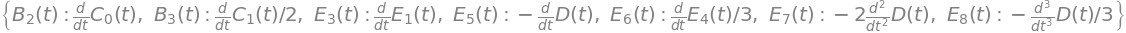

In [31]:
v = [B2, B3, E8, E7, E5, E3, E6]
s = sympy.solve(eqs3[-9:-2], v)
display(s)
for eq in eqs3:
    display(compact(eq.subs(s).doit()))

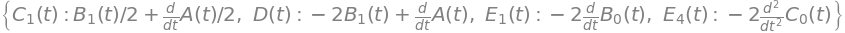

In [32]:
v1 = [C1, D, E1, E4]
s1 = sympy.solve([eq.subs(s).doit() for eq in eqs3[:1] + eqs3[2:5]], v1)
display(s1)
for eq in eqs3:
    display(compact(eq.subs(s).doit().subs(s1).doit()))

In [33]:
A0 = sympy.Symbol('A0')
s2 = {B1: A.diff(t)/3 + A0}
for eq in eqs3:
    display(compact(eq.subs(s).doit().subs(s1).doit().subs(s2).doit()))

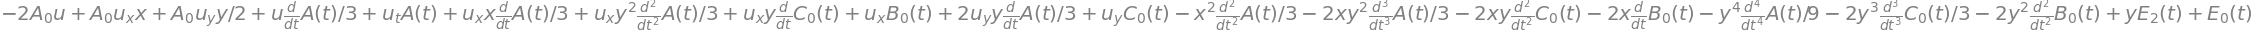

In [34]:
F3 = sum(i*j for i, j in zip(F3, (ut, ux, uy, u, 1))).\
    subs(s).doit().subs(s1).doit().subs(s2).doit().expand()
F3

In [35]:
eq3.subs({F: F3}).doit().subs({ux: U.diff(x)}).expand()

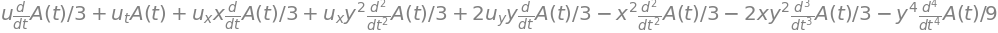

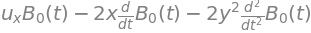

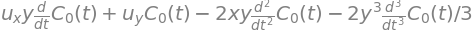

In [36]:
for a in (A, B0, C0, E0, E2):
    display(sum(i for i in F3.args if a in i.atoms(sympy.Function)))

In [37]:
F3.coeff(A0)

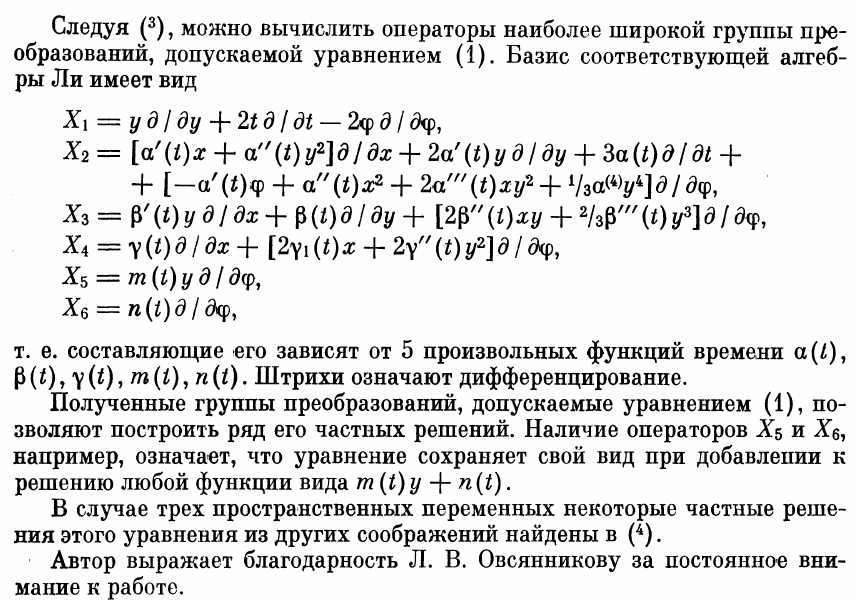

In [39]:
Image('Мамонтов2.png')